In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_41750/3244023466.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds_version = "weseraue"
root_data_path = os.path.join("..", "data", ds_version)
data_path = os.path.join(root_data_path, "prediction")

confidence_threshold = 0.9

In [3]:
# with cropping
file_name = "effnet_surface_quality_prediction-weseraue_paving_stones-20240709_094632.csv"

In [4]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [7]:
pred = pd.DataFrame()

# print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, file_name))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = pred.groupby("image_id")["class_prob"].idxmax()
type_pred = pred.loc[idx].reset_index()
# pred = pred[pred["type_pred"] == "paving_stones"]

type_pred["type_true"] = "paving_stones"
df = type_pred.set_index("image_id")
df_high_conf = df[df["class_prob"]>confidence_threshold]

gm = compute_measures_cat(df.type_true, df.type_pred)
gm = round(gm['accuracy'], 3)
gm_high_conf = compute_measures_cat(df_high_conf.type_true, df_high_conf.type_pred)
gm_high_conf = round(gm_high_conf['accuracy'], 3)

cm = confusion_matrix(df.type_true, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
cm_high_conf = confusion_matrix(df_high_conf.type_true, df_high_conf.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])

In [8]:
print(f"Acc: {gm}")
print(f"Acc limited to high confidence predictions: {gm_high_conf}")

Acc: 0.236
Acc limited to high confidence predictions: 0.444


In [9]:
def plot_conf_matrix_2(cm_1, cm_2, model, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[0])
    ax[0].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Annotated")
    sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                ax=ax[1])
    ax[1].set_title(f"Confusion Matrix for model {model} and dataset {dataset}")
    ax[1].set_xlabel(f"Predicted with probability > {confidence_threshold}")
    ax[1].set_ylabel("Annotated")
    plt.tight_layout()
    plt.show()

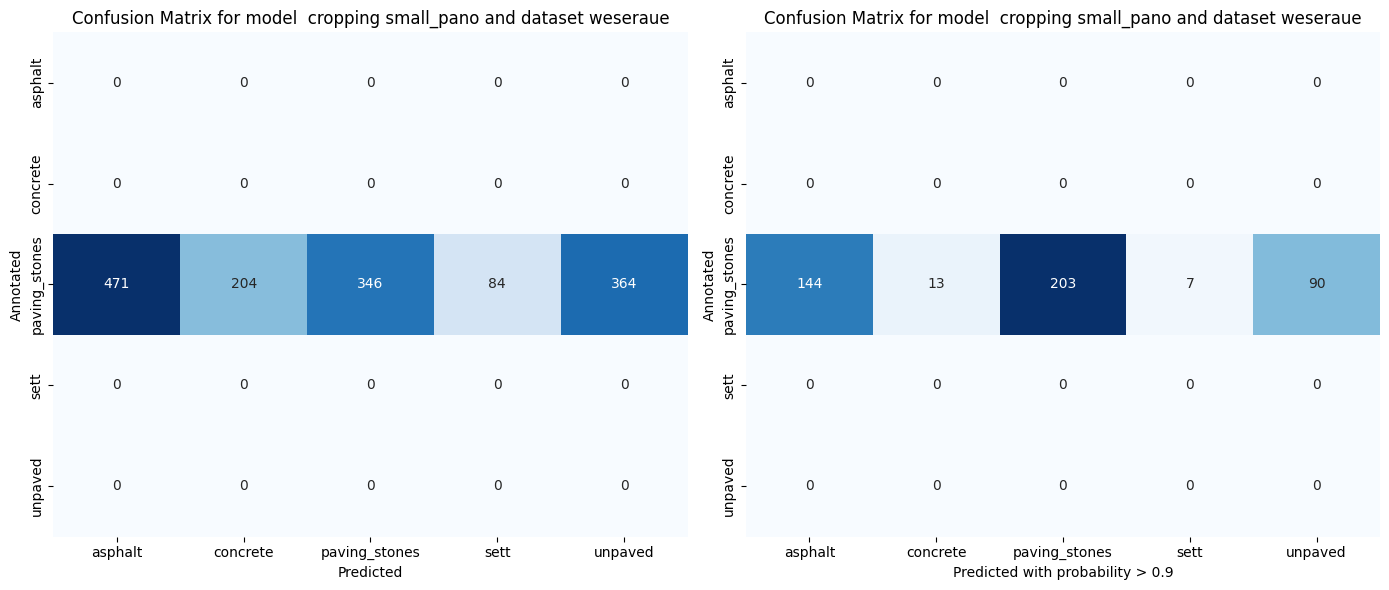

In [10]:
plot_conf_matrix_2(cm, cm_high_conf, " cropping small_pano", "weseraue")

## Measures by surface class

In [72]:
# all
# gm_surface = pd.DataFrame()
# for surface in df.surface_true.unique():
#     df_ = df[df.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

In [73]:
# all
# gm_surface = pd.DataFrame()
# for surface in df.surface_true.unique():
#     df_ = df[df.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

In [74]:
# only validation
# gm_surface = pd.DataFrame()
# for surface in df_valid.surface_true.unique():
#     df_ = df_valid[df_valid.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

## compare float values

In [75]:
df = df_valid
# df = df_train

In [76]:
# Plot
# np.random.seed(5)
# colors = {surface_type: np.random.rand(3,) for surface_type in df.surface_true.unique()}

# sns.scatterplot(data=df, x="quality_float_true", y="quality_float_pred", hue="surface_true", palette=colors, legend="full")
# plt.xlabel('True')
# plt.ylabel('Pred')
# plt.title('True vs. Pred quality by surface')
# plt.show()


In [77]:
# sns.set_style("whitegrid")

# # Create a FacetGrid
# g = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# # Map scatter plot for each surface type
# g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

# plt.show()

#### Hom much do the deviate?

In [78]:
# df["deviation"] = df.quality_float_true - df.quality_float_pred

**Overall**

In [79]:
# df.deviation.hist(bins=20)

**by surface**

In [80]:
# # Create a FacetGrid for histograms
# g_hist = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# # Map histogram for deviation for each surface type
# g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

# plt.show()

## compare classes

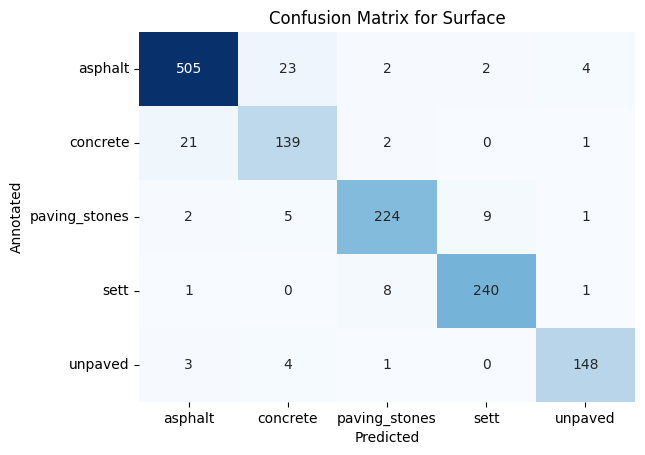

In [81]:
# Plotting the confusion matrix using seaborn heatmap

cm = confusion_matrix(df.surface_true, df.surface_label_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.title(f"Confusion Matrix for Surface")
plt.xlabel("Predicted")
plt.ylabel("Annotated")
plt.show()

In [82]:
# Extract predicted and ground truth values

class_precision = precision_score(df.surface_true, df.surface_label_pred, average='weighted')
class_recall = recall_score(df.surface_true, df.surface_label_pred, average='weighted')

print(f"Count: {len(df)}")
print(f"Precision: {round(class_precision, 2)}")
print(f"Recall: {round(class_recall, 2)}")
print("------------------------")


Count: 1346
Precision: 0.93
Recall: 0.93
------------------------


In [83]:
# all images that were incorrectly classified
misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

In [84]:
misclassification = misclassification.sort_values("image_id")
misclassification.reset_index( inplace=True)
misclassification[["image_id", "is_in_validation", 
                   "surface_true", "surface_label_pred", "quality_label_true"]
                   ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)

In [85]:
# store missclassified images in folder
import shutil

path = os.path.join(data_path, "model_predictions", "misclassified_images", "surface")
os.makedirs(path, exist_ok=True)
for i in range(len(misclassification)):  # len(misclassification)
    img = misclassification.loc[i]
    img_path = os.path.join(root_data_path, "annotated")
    destination_folder_path = os.path.join(path, img.surface_true, img.surface_label_pred)
    os.makedirs(destination_folder_path, exist_ok=True)
    destination_path = os.path.join(destination_folder_path, f"{img.image_id}.jpg")
    image_filename = os.path.join(img_path, img.surface_true, img.quality_label_true, f"{img.image_id}.jpg")
    shutil.copy(image_filename, destination_folder_path)

In [52]:
# store missclassified images in folder
# path = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/model_predictions/VGG16_V4_not_annotated/missclassified_wo_nostreet"
# os.makedirs(path, exist_ok=True)
# for image_id in misclassification_wo_nostreet.index:
#     destination_path = os.path.join(path, f"{image_id}.jpg")
#     image_filename = os.path.join("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/unsorted_images", f"{image_id}.jpg")
#     shutil.copy(image_filename, destination_path)